In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
import statsmodels.api as sm
%matplotlib inline

In [2]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [3]:
file =  '/glade/scratch/djk2120/clm5ppe/ens004/histSTEP3/PPEn08_I2000_stemleaf_STEP3.clm2.h0.0001-01-01-00000.nc'
sl = xr.open_dataset(file)

In [15]:
file = '/glade/scratch/djk2120/stemleaf_step3/run/stemleaf_step3.clm2.h0.0001-01-01-00000.nc'
sl2 = xr.open_dataset(file)

In [6]:
t = sl['time.year']

In [14]:
la = xr.open_dataset('sparsegrid_landarea.nc').landarea

Text(0.5, 1.0, 'stemleaf, step3')

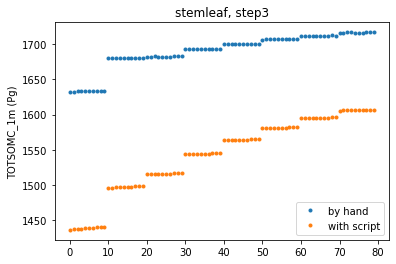

In [27]:
plt.plot((1e-9*la*sl2.TOTSOMC_1m.isel(time=t>1)).sum(dim='gridcell'),'.')
plt.plot((1e-9*la*sl.TOTSOMC_1m.isel(time=t>1)).sum(dim='gridcell'),'.')
plt.legend(['by hand','with script'],loc=4)
plt.ylabel('TOTSOMC_1m (Pg)')
plt.title('stemleaf, step3')

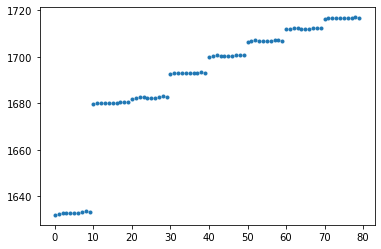

In [2]:
thedir = '/glade/scratch/oleson/archive/ctsm51c6_PPEn05cnmatrixn04ctsm51d023_2deg_GSWP3V1_Sparse400_fullout_2000pAD/lnd/hist/'
thefiles = sorted(glob.glob(thedir+'*.h0.*'))

In [78]:
ds = xr.open_mfdataset(thefiles[-240:],combine='by_coords')

In [79]:
nmonths = len(ds.time)
yr0 = ds['time.year'][0].values
ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

In [4]:
thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
c = xr.open_dataset(thedir+thefile)

In [47]:
k = -1
nlat = len(ds.lat)
nlon = len(ds.lon)

rarea = np.zeros([nlat,nlon])
for i in range(nlat):
    for j in range(nlon):
        if landarea[i,j]>0:
            cclass = c.cclass[i,j]
            ix     = c.cclass==cclass
            rarea[i,j] = la2.values[ix].sum()
            
            

In [55]:
la_grid = xr.DataArray(rarea,coords=[c.lat,c.lon],name='landarea_2d')
la_grid.attrs={'long_name':'total area of represented gridcells',
          'units':'km2'}

In [56]:
la['landarea_2d'] = la_grid

In [58]:
la.to_netcdf('sparsegrid_landarea2.nc')

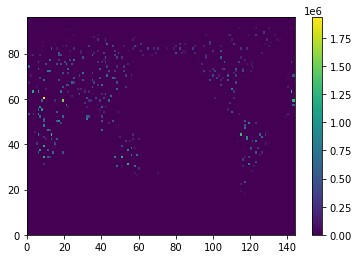

In [49]:
plt.pcolormesh(rarea)
plt.colorbar()

In [45]:
landarea = (ds.area*ds.landfrac).isel(time=0)
la2 = c.area*c.landfrac

<xarray.DataArray 'landarea_2d' (lat: 96, lon: 144)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:  total area of represented gridcells
    units:      km2

In [84]:
somc1m = 1e-9*(la.landarea_2d*(month_wts(20)/365*ds.TOTSOMC_1m).groupby('time.year').sum()).sum(dim=['lat','lon']).compute()

In [82]:
somc1m = somc1m.values

array([1625.14310271, 1625.41020978, 1625.60607027, 1625.49626985,
       1625.40576082, 1625.34364429, 1625.21883626, 1625.44196488,
       1625.70030888, 1625.42085532, 1625.22174031, 1625.48445275,
       1625.6674505 , 1625.56129132, 1625.45706559, 1625.40354757,
       1625.30789874, 1625.50775988, 1625.77114648, 1625.50207948])

Text(0.5, 1.0, 'postAD last 20 years')

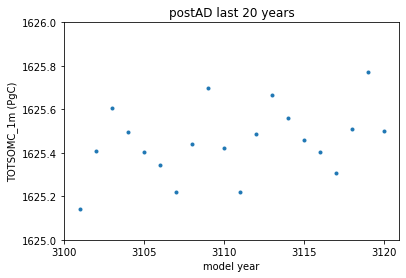

In [91]:
plt.plot(ds['time.year'].groupby('time.year').mean(),somc1m,'.')
plt.ylim([1625,1626])
plt.xticks(3100+5*np.arange(5));
plt.xlabel('model year')
plt.ylabel('TOTSOMC_1m (PgC)')
plt.title('postAD last 20 years')

In [99]:
somc1m[10]-somc1m[0]

<xarray.DataArray ()>
array(0.0786376)

In [97]:
y = somc1m.values.reshape([-1,1])
x = np.arange(20).reshape([-1,1])
x = sm.add_constant(x)

fit = sm.OLS(y,x).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     2.505
Date:                Wed, 24 Mar 2021   Prob (F-statistic):              0.131
Time:                        15:48:33   Log-Likelihood:                 9.8768
No. Observations:                  20   AIC:                            -15.75
Df Residuals:                      18   BIC:                            -13.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1625.3628      0.067   2.42e+04      0.000    1625.222    1625.504
x1             0.0096      0.006      1.583      0.131      -0.003       0.022
==============================================================================
Omnibus:                        0.534   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.766   Jarque-Bera (JB):                0.597
Skew:                           0.128   Prob(JB):                        0.742
Kurtosis:                       2.193   Cond. No.                         21.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""